# Event Impact Analysis (HYP-EVENTS)

**Phase 3:** Policy Deep Dives & Event Impacts

## Objective

Measure the impact of major events (sports games, holidays, celebrations) on crime patterns in Philadelphia using difference-in-means analysis with proper statistical testing.

## Overview

This notebook answers the question: **Do crime patterns change significantly on event days?**

We analyze:
1. **Sports events**: Eagles, Phillies, 76ers, Flyers home games
2. **Holidays**: Major federal and local holidays
3. **Celebrations**: Special events and festivals

## Outputs

- `reports/event_impact_chart.png` - Comparison visualization
- `reports/event_impact_summary.md` - Summary report with statistical findings
- `reports/event_impact_results.csv` - Full results table

In [1]:
# Parameters (can be injected by papermill)
VERSION = "v1.0"
FAST_MODE = False

In [2]:
import time
from pathlib import Path
import sys

RUNTIME_START = time.time()

# Robust repo_root detection: works from notebooks/ dir or project root
cwd = Path.cwd()
if cwd.name == 'notebooks':
    repo_root = cwd.parent
else:
    repo_root = cwd

# Add to path for imports
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

REPORTS_DIR = repo_root / 'reports'
REPORTS_DIR.mkdir(exist_ok=True)

print(f"Repo root: {repo_root}")
print(f"Reports dir: {REPORTS_DIR}")

Repo root: /Users/dustinober/Projects/Crime Incidents Philadelphia
Reports dir: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


In [3]:
# Reproducibility info
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("Environment versions:")
print(f"  Python: {sys.version.split()[0]}")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  matplotlib: {matplotlib.__version__}")
print(f"  scipy: {stats.scipy_version}" if hasattr(stats, 'scipy_version') else "  scipy: available")

# Artifact tracking
artifacts = []

Environment versions:
  Python: 3.13.9
  pandas: 2.3.3
  numpy: 2.3.5
  matplotlib: 3.10.6
  scipy: available


## 1. Data Loading

Load crime incidents and event calendar data.

In [4]:
from analysis.utils import load_data, classify_crime_category

# Load and classify crime data
df = load_data(clean=True)
df = classify_crime_category(df)

print(f"Total crime incidents: {len(df):,}")
print(f"Date range: {df['dispatch_date'].min().date()} to {df['dispatch_date'].max().date()}")
print(f"\nCrime categories:")
print(df['crime_category'].value_counts())

Total crime incidents: 3,496,353
Date range: 2006-01-01 to 2026-01-20

Crime categories:
crime_category
Other       2064830
Property    1098225
Violent      333298
Name: count, dtype: int64


In [5]:
# Load event calendar
events = pd.read_parquet(repo_root / 'data' / 'external' / 'event_calendar.parquet')
events['date'] = pd.to_datetime(events['date']).dt.normalize()

print(f"Event calendar entries: {len(events):,}")
print(f"Date range: {events['date'].min().date()} to {events['date'].max().date()}")
print(f"\nEvent types:")
print(events['event_type'].value_counts())
print(f"\nTeams represented:")
print(events['team'].value_counts())

Event calendar entries: 1,105
Date range: 2015-01-01 to 2026-04-10

Event types:
event_type
sports         968
holiday        115
celebration     22
Name: count, dtype: int64

Teams represented:
team
Phillies    440
Flyers      220
76ers       220
Eagles       88
Name: count, dtype: int64


## 2. Prepare Daily Crime Counts

Aggregate crime data to daily counts for comparison.

In [6]:
# Normalize dispatch date
df['date'] = pd.to_datetime(df['dispatch_date']).dt.normalize()

# Daily counts by category
daily_total = df.groupby('date').size().reset_index(name='total')
daily_violent = df[df['crime_category'] == 'Violent'].groupby('date').size().reset_index(name='violent')
daily_property = df[df['crime_category'] == 'Property'].groupby('date').size().reset_index(name='property')

# Merge
daily = daily_total.merge(daily_violent, on='date', how='left')
daily = daily.merge(daily_property, on='date', how='left')
daily = daily.fillna(0)

# Add temporal features
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['year'] = daily['date'].dt.year
daily['month'] = daily['date'].dt.month

# Filter to overlapping analysis period
analysis_start = max(df['date'].min(), events['date'].min())
analysis_end = min(df['date'].max(), events['date'].max())
daily = daily[(daily['date'] >= analysis_start) & (daily['date'] <= analysis_end)]

print(f"Analysis period: {analysis_start.date()} to {analysis_end.date()}")
print(f"Total days in analysis: {len(daily):,}")
print(f"\nDaily crime statistics:")
print(daily[['total', 'violent', 'property']].describe().round(1))

Analysis period: 2015-01-01 to 2026-01-20
Total days in analysis: 4,037

Daily crime statistics:
        total  violent  property
count  4037.0   4037.0    4037.0
mean    426.7     40.3     149.8
std      74.6      8.9      44.7
min      61.0      9.0      17.0
25%     377.0     34.0     117.0
50%     430.0     40.0     141.0
75%     478.0     46.0     179.0
max     855.0    134.0     485.0


## 3. Tag Event Days

Identify event days and create indicator variables for different event types.

In [7]:
# Tag all event days
event_dates = set(events['date'])
daily['is_event'] = daily['date'].isin(event_dates)

# Tag by event type
for event_type in events['event_type'].unique():
    type_dates = set(events[events['event_type'] == event_type]['date'])
    daily[f'is_{event_type}'] = daily['date'].isin(type_dates)

# Tag by team for sports events
sports_df = events[events['event_type'] == 'sports']
for team in ['Eagles', 'Phillies', '76ers', 'Flyers']:
    team_dates = set(sports_df[sports_df['team'] == team]['date'])
    daily[f'is_{team.lower()}'] = daily['date'].isin(team_dates)

# Summary
print("Event day counts:")
print(f"  Any event: {daily['is_event'].sum():,}")
print(f"  Sports: {daily['is_sports'].sum():,}")
print(f"  Holidays: {daily['is_holiday'].sum():,}")
if 'is_celebration' in daily.columns:
    print(f"  Celebrations: {daily['is_celebration'].sum():,}")
print(f"\nBy team:")
for team in ['eagles', 'phillies', '76ers', 'flyers']:
    print(f"  {team.title()}: {daily[f'is_{team}'].sum():,}")

Event day counts:
  Any event: 986
  Sports: 890
  Holidays: 115
  Celebrations: 22

By team:
  Eagles: 88
  Phillies: 440
  76Ers: 211
  Flyers: 212


## 4. Difference-in-Means Analysis

Compare crime counts on event days vs. non-event days using statistical tests.

In [8]:
def calculate_impact(daily_df, event_col, metric='total'):
    """Calculate difference-in-means for event vs control days.
    
    Parameters
    ----------
    daily_df : pd.DataFrame
        Daily crime counts with event indicators
    event_col : str
        Column name for event indicator (e.g., 'is_sports')
    metric : str
        Crime metric to analyze ('total', 'violent', 'property')
        
    Returns
    -------
    dict
        Impact statistics including means, difference, p-value
    """
    event_days = daily_df[daily_df[event_col]]
    control_days = daily_df[~daily_df['is_event']]  # Non-event days as controls
    
    if len(event_days) == 0:
        return None
    
    event_mean = event_days[metric].mean()
    control_mean = control_days[metric].mean()
    diff = event_mean - control_mean
    pct_change = (diff / control_mean * 100) if control_mean > 0 else 0
    
    # Two-sample t-test
    t_stat, p_value = stats.ttest_ind(event_days[metric], control_days[metric])
    
    # Bootstrap 95% CI for difference
    np.random.seed(42)
    n_bootstrap = 1000
    diffs = []
    for _ in range(n_bootstrap):
        e_sample = event_days[metric].sample(len(event_days), replace=True)
        c_sample = control_days[metric].sample(len(event_days), replace=True)
        diffs.append(e_sample.mean() - c_sample.mean())
    
    ci_lower = np.percentile(diffs, 2.5)
    ci_upper = np.percentile(diffs, 97.5)
    
    return {
        'event_type': event_col.replace('is_', ''),
        'metric': metric,
        'n_event_days': len(event_days),
        'n_control_days': len(control_days),
        'event_mean': event_mean,
        'control_mean': control_mean,
        'difference': diff,
        'pct_change': pct_change,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

In [9]:
# Define event types to analyze
event_cols = ['is_holiday', 'is_sports']
if 'is_celebration' in daily.columns:
    event_cols.append('is_celebration')
    
# Add team-specific columns if they have enough events
for team in ['eagles', 'phillies', '76ers', 'flyers']:
    col = f'is_{team}'
    if daily[col].sum() >= 10:  # Minimum sample size
        event_cols.append(col)

metrics = ['total', 'violent', 'property']

# Run analysis
results = []
for event_col in event_cols:
    for metric in metrics:
        result = calculate_impact(daily, event_col, metric)
        if result:
            results.append(result)

results_df = pd.DataFrame(results)

print(f"Total tests run: {len(results_df)}")
print(f"Significant results (p < 0.05): {results_df['significant'].sum()}")

Total tests run: 21
Significant results (p < 0.05): 14


In [10]:
# Display formatted results
display_cols = ['event_type', 'metric', 'n_event_days', 'event_mean', 'control_mean', 
                'pct_change', 'p_value', 'significant']
display_df = results_df[display_cols].copy()
display_df['event_mean'] = display_df['event_mean'].round(1)
display_df['control_mean'] = display_df['control_mean'].round(1)
display_df['pct_change'] = display_df['pct_change'].round(2)
display_df['p_value'] = display_df['p_value'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")

print("\nEvent Impact Analysis Results:")
print("="*80)
display(display_df)


Event Impact Analysis Results:


,event_type,metric,n_event_days,event_mean,control_mean,pct_change,p_value,significant
0,holiday,total,115,369.1,429.6,-14.08,<0.0001,True
1,holiday,violent,115,39.3,40.3,-2.67,0.2117,False
2,holiday,property,115,137.3,150.3,-8.63,0.0023,True
3,sports,total,890,423.5,429.6,-1.43,0.0283,True
4,sports,violent,890,40.4,40.3,0.06,0.9404,False
5,sports,property,890,150.0,150.3,-0.13,0.9049,False
6,celebration,total,22,390.2,429.6,-9.17,0.0122,True
7,celebration,violent,22,39.2,40.3,-2.88,0.5459,False
8,celebration,property,22,140.3,150.3,-6.64,0.2952,False
9,eagles,total,88,367.7,429.6,-14.42,<0.0001,True


## 5. Visualizations

Create charts showing event impacts with confidence intervals.

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/event_impact_chart.png


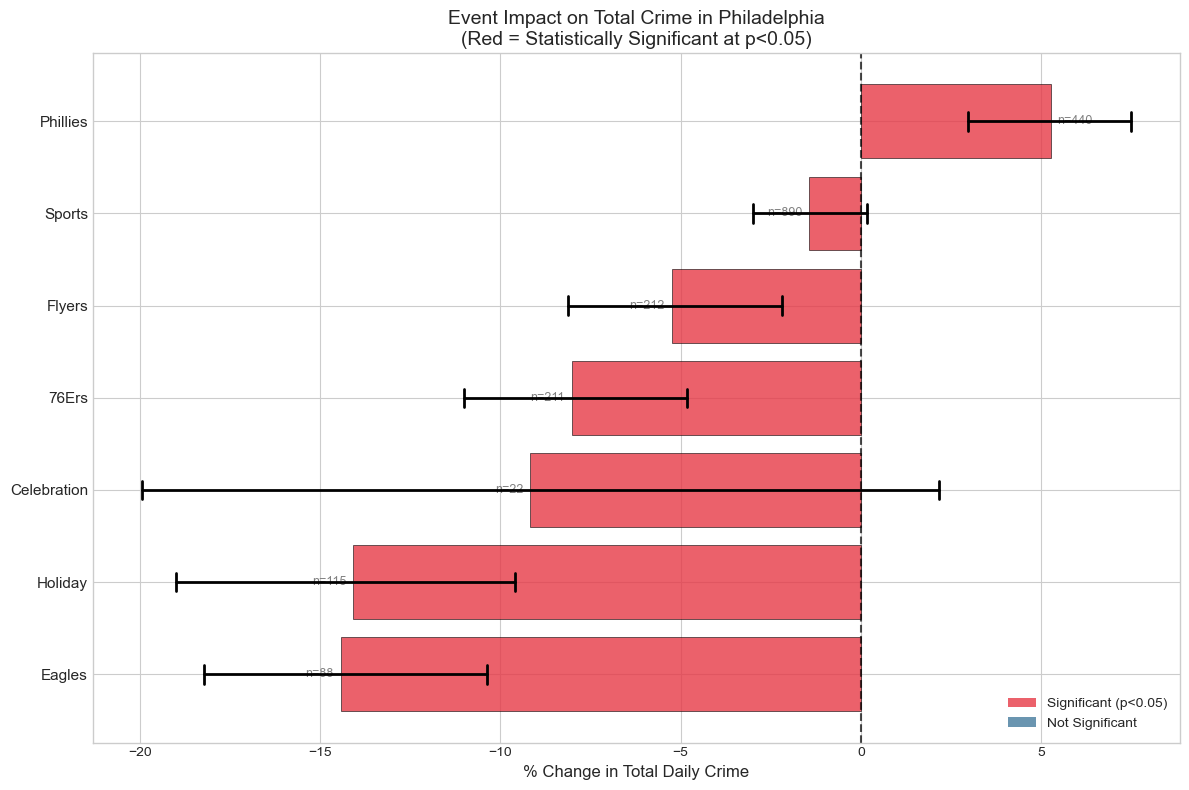

In [11]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Filter to total crimes for main comparison
total_results = results_df[results_df['metric'] == 'total'].copy()
total_results = total_results.sort_values('pct_change', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(total_results))
colors = ['#E63946' if sig else '#457B9D' for sig in total_results['significant']]

# Plot bars
bars = ax.barh(y_pos, total_results['pct_change'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add confidence intervals (convert to pct change)
for i, (_, row) in enumerate(total_results.iterrows()):
    ci_low_pct = (row['ci_lower'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
    ci_high_pct = (row['ci_upper'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
    ax.plot([ci_low_pct, ci_high_pct], [i, i], 'k-', linewidth=2, zorder=5)
    ax.plot([ci_low_pct, ci_low_pct], [i-0.1, i+0.1], 'k-', linewidth=2)
    ax.plot([ci_high_pct, ci_high_pct], [i-0.1, i+0.1], 'k-', linewidth=2)

# Zero reference line
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Labels
ax.set_yticks(y_pos)
ax.set_yticklabels([r['event_type'].replace('_', ' ').title() for _, r in total_results.iterrows()], fontsize=11)
ax.set_xlabel('% Change in Total Daily Crime', fontsize=12)
ax.set_title('Event Impact on Total Crime in Philadelphia\n(Red = Statistically Significant at p<0.05)', fontsize=14)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#E63946', alpha=0.8, label='Significant (p<0.05)'),
    Patch(facecolor='#457B9D', alpha=0.8, label='Not Significant')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Add annotation for sample sizes
for i, (_, row) in enumerate(total_results.iterrows()):
    ax.annotate(f"n={row['n_event_days']:,}", 
                xy=(row['pct_change'], i),
                xytext=(5 if row['pct_change'] >= 0 else -5, 0),
                textcoords='offset points',
                ha='left' if row['pct_change'] >= 0 else 'right',
                va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'event_impact_chart.png', dpi=300, bbox_inches='tight', facecolor='white')
artifacts.append(('event_impact_chart.png', 'Event impact comparison chart'))
print(f"Saved: {REPORTS_DIR / 'event_impact_chart.png'}")
plt.show()

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/event_impact_by_category.png


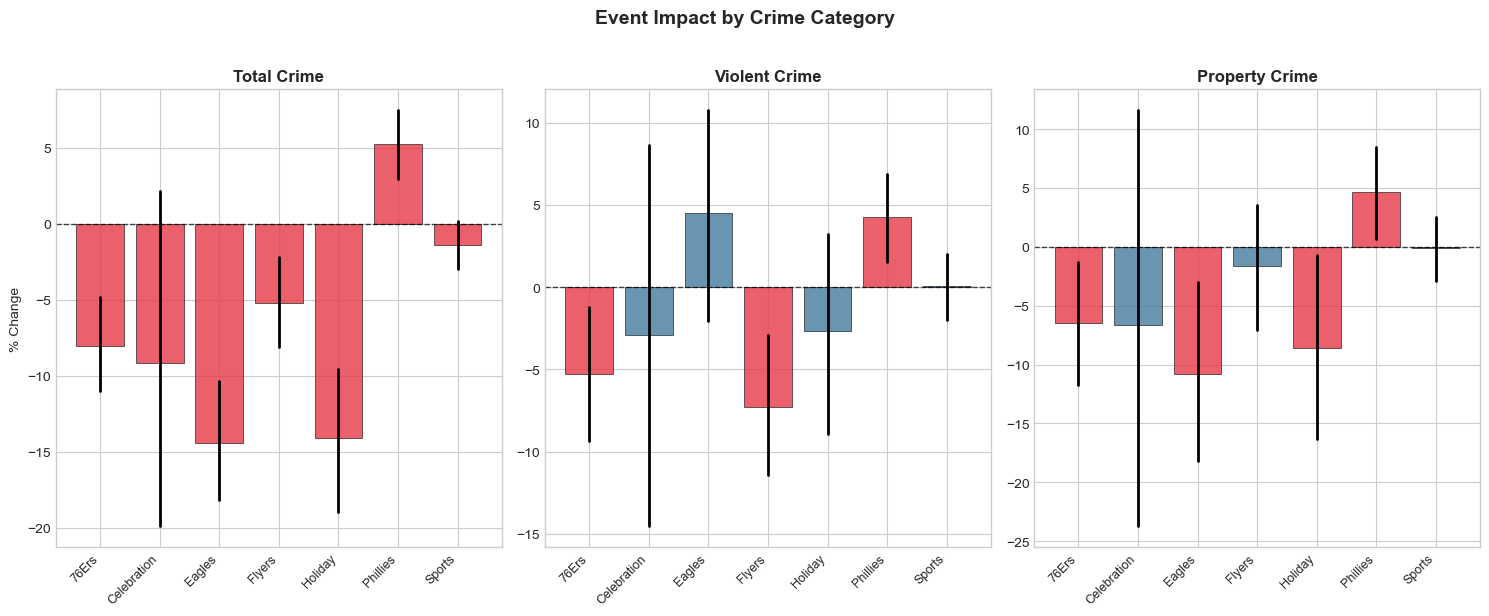

In [12]:
# Create comparison chart by crime category
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for i, metric in enumerate(['total', 'violent', 'property']):
    ax = axes[i]
    metric_results = results_df[results_df['metric'] == metric].copy()
    metric_results = metric_results.sort_values('event_type')
    
    x = range(len(metric_results))
    colors = ['#E63946' if s else '#457B9D' for s in metric_results['significant']]
    
    bars = ax.bar(x, metric_results['pct_change'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add error bars
    for j, (_, row) in enumerate(metric_results.iterrows()):
        ci_low_pct = (row['ci_lower'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
        ci_high_pct = (row['ci_upper'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
        ax.plot([j, j], [ci_low_pct, ci_high_pct], 'k-', linewidth=2)
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([e.replace('is_', '').replace('_', ' ').title() 
                        for e in metric_results['event_type']], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('% Change' if i == 0 else '')
    ax.set_title(f'{metric.title()} Crime', fontsize=12, fontweight='bold')

plt.suptitle('Event Impact by Crime Category', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'event_impact_by_category.png', dpi=300, bbox_inches='tight', facecolor='white')
artifacts.append(('event_impact_by_category.png', 'Impact by crime category'))
print(f"Saved: {REPORTS_DIR / 'event_impact_by_category.png'}")
plt.show()

## 6. Spillover Analysis

Examine whether crime effects extend to days before/after events.

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/event_spillover.png


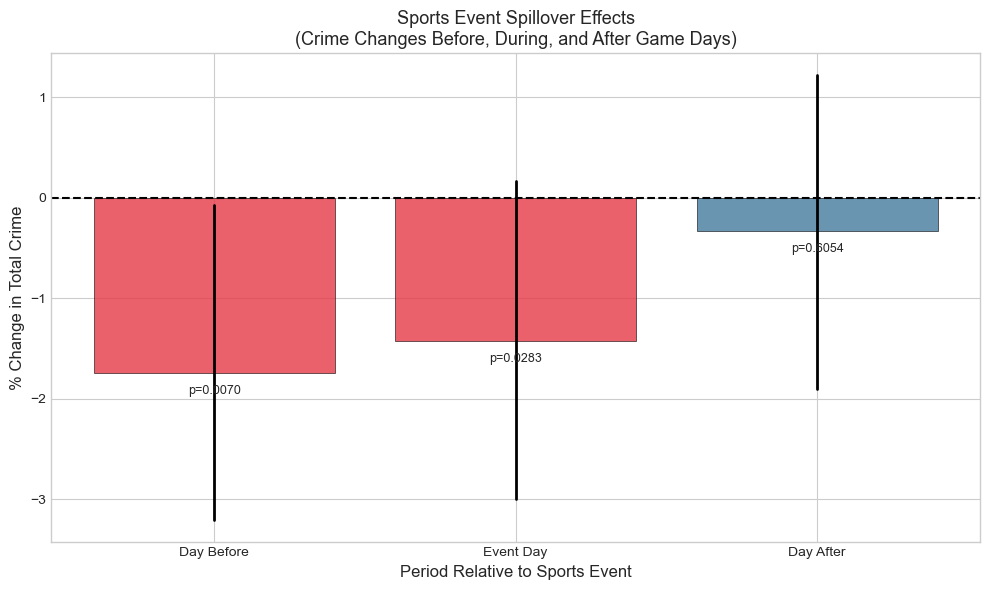


Spillover Analysis Results:
       period  n_event_days  pct_change   p_value  significant
0  Day Before           890   -1.743849  0.006959         True
1   Event Day           890   -1.430023  0.028342         True
2   Day After           890   -0.335292  0.605397        False


In [13]:
# Check day before and after sports events
sports_dates = sorted(set(sports_df['date']))

spillover_results = []
for offset, label in [(-1, 'Day Before'), (0, 'Event Day'), (1, 'Day After')]:
    offset_dates = set([d + pd.Timedelta(days=offset) for d in sports_dates])
    daily['is_spillover'] = daily['date'].isin(offset_dates)
    
    if daily['is_spillover'].sum() > 0:
        result = calculate_impact(daily, 'is_spillover', 'total')
        if result:
            result['period'] = label
            spillover_results.append(result)

spillover_df = pd.DataFrame(spillover_results)

if len(spillover_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    periods = spillover_df['period'].tolist()
    changes = spillover_df['pct_change'].tolist()
    colors = ['#E63946' if s else '#457B9D' for s in spillover_df['significant']]
    
    bars = ax.bar(periods, changes, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add error bars
    for j, (_, row) in enumerate(spillover_df.iterrows()):
        ci_low_pct = (row['ci_lower'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
        ci_high_pct = (row['ci_upper'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
        ax.plot([j, j], [ci_low_pct, ci_high_pct], 'k-', linewidth=2)
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    ax.set_ylabel('% Change in Total Crime', fontsize=12)
    ax.set_xlabel('Period Relative to Sports Event', fontsize=12)
    ax.set_title('Sports Event Spillover Effects\n(Crime Changes Before, During, and After Game Days)', fontsize=13)
    
    # Add p-value annotations
    for j, (_, row) in enumerate(spillover_df.iterrows()):
        p_text = f"p={row['p_value']:.4f}" if row['p_value'] >= 0.0001 else "p<0.0001"
        ax.annotate(p_text, xy=(j, row['pct_change']), 
                    xytext=(0, 10 if row['pct_change'] >= 0 else -15),
                    textcoords='offset points', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'event_spillover.png', dpi=300, bbox_inches='tight', facecolor='white')
    artifacts.append(('event_spillover.png', 'Event spillover effects'))
    print(f"Saved: {REPORTS_DIR / 'event_spillover.png'}")
    plt.show()
    
    print("\nSpillover Analysis Results:")
    print(spillover_df[['period', 'n_event_days', 'pct_change', 'p_value', 'significant']])
else:
    print("Insufficient data for spillover analysis")

## 7. Summary Report

Generate markdown report with findings.

In [14]:
# Identify key findings
sig_results = results_df[results_df['significant']]
n_significant = len(sig_results)
n_tests = len(results_df)

# Find largest effects
if len(sig_results) > 0:
    max_increase = sig_results[sig_results['pct_change'] > 0].sort_values('pct_change', ascending=False)
    max_decrease = sig_results[sig_results['pct_change'] < 0].sort_values('pct_change', ascending=True)
else:
    max_increase = pd.DataFrame()
    max_decrease = pd.DataFrame()

# Build report
report_content = f"""# Event Impact Analysis Report

## Executive Summary

This analysis examines the impact of major events (sports games, holidays, celebrations) on crime patterns in Philadelphia using difference-in-means testing.

**Analysis Period:** {analysis_start.date()} to {analysis_end.date()}  
**Total Days Analyzed:** {len(daily):,}  
**Event Days:** {daily['is_event'].sum():,}  
**Control Days:** {(~daily['is_event']).sum():,}

### Key Finding

**{n_significant} of {n_tests} tests** showed statistically significant results (p < 0.05).

"""

# Add significant findings section
if n_significant > 0:
    report_content += """## Significant Impacts

The following event-crime combinations showed statistically significant differences:

| Event Type | Crime Metric | % Change | 95% CI | p-value |
|------------|--------------|----------|--------|--------|
"""
    for _, row in sig_results.iterrows():
        ci_low_pct = (row['ci_lower'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
        ci_high_pct = (row['ci_upper'] / row['control_mean'] * 100) if row['control_mean'] > 0 else 0
        ci_str = f"[{ci_low_pct:+.1f}%, {ci_high_pct:+.1f}%]"
        p_str = f"{row['p_value']:.4f}" if row['p_value'] >= 0.0001 else "<0.0001"
        report_content += f"| {row['event_type'].replace('_', ' ').title()} | {row['metric'].title()} | {row['pct_change']:+.1f}% | {ci_str} | {p_str} |\n"
else:
    report_content += """## Significant Impacts

No statistically significant impacts were detected at the p < 0.05 level.
"""

# Add interpretation
if len(max_increase) > 0:
    top_inc = max_increase.iloc[0]
    report_content += f"""
### Largest Crime Increase

**{top_inc['event_type'].replace('_', ' ').title()}** events showed a **{top_inc['pct_change']:+.1f}%** increase in {top_inc['metric']} crime (p={top_inc['p_value']:.4f}).
"""

if len(max_decrease) > 0:
    top_dec = max_decrease.iloc[0]
    report_content += f"""
### Largest Crime Decrease

**{top_dec['event_type'].replace('_', ' ').title()}** events showed a **{top_dec['pct_change']:+.1f}%** decrease in {top_dec['metric']} crime (p={top_dec['p_value']:.4f}).
"""

# Add all results table
report_content += """
## Complete Results Summary

### Total Crime by Event Type

| Event Type | Event Days | Event Mean | Control Mean | % Change | p-value | Significant |
|------------|------------|------------|--------------|----------|---------|-------------|
"""

for _, row in results_df[results_df['metric'] == 'total'].iterrows():
    p_str = f"{row['p_value']:.4f}" if row['p_value'] >= 0.0001 else "<0.0001"
    sig_str = "Yes" if row['significant'] else "No"
    report_content += f"| {row['event_type'].replace('_', ' ').title()} | {row['n_event_days']:,} | {row['event_mean']:.1f} | {row['control_mean']:.1f} | {row['pct_change']:+.1f}% | {p_str} | {sig_str} |\n"

# Add methodology
report_content += f"""
## Methodology

### Event Types Analyzed

- **Sports**: Home games for Eagles, Phillies, 76ers, and Flyers
- **Holidays**: Major federal holidays (New Year's Day, Memorial Day, July 4th, Labor Day, Thanksgiving)
- **Celebrations**: Special events and festivals

### Statistical Approach

1. **Daily Aggregation**: Crime incidents aggregated to daily counts
2. **Event Tagging**: Days tagged as event or control based on event calendar
3. **Difference-in-Means**: Two-sample t-test comparing event vs non-event days
4. **Confidence Intervals**: Bootstrap 95% CI (1,000 iterations)
5. **Significance Level**: p < 0.05

### Data Sources

- Crime data: Philadelphia Police Department incidents ({df['dispatch_date'].min().date()} to {df['dispatch_date'].max().date()})
- Event calendar: Generated from team schedules and holiday definitions

## Caveats and Limitations

1. **Correlation vs Causation**: Associations do not imply causal relationships
2. **Confounding Factors**: Weather, concurrent events, and seasonal patterns not controlled
3. **Multiple Testing**: {n_tests} tests increase false positive risk (consider Bonferroni correction: p < {0.05/n_tests:.4f})
4. **Schedule Approximations**: Sports schedules are estimates and may not perfectly match actual home games
5. **Reporting Bias**: Event days may have different crime reporting patterns

## Visualizations

- `event_impact_chart.png`: Main comparison of event types
- `event_impact_by_category.png`: Breakdown by crime category
- `event_spillover.png`: Day before/after effects for sports events

---
*Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}*  
*Notebook: event_impact_analysis.ipynb*
"""

# Save report
with open(REPORTS_DIR / 'event_impact_summary.md', 'w') as f:
    f.write(report_content)

artifacts.append(('event_impact_summary.md', 'Event impact summary report'))
print(f"Saved: {REPORTS_DIR / 'event_impact_summary.md'}")
print("\n" + "="*60)
print("REPORT PREVIEW:")
print("="*60)
print(report_content[:2000] + "...")

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/event_impact_summary.md

REPORT PREVIEW:
# Event Impact Analysis Report

## Executive Summary

This analysis examines the impact of major events (sports games, holidays, celebrations) on crime patterns in Philadelphia using difference-in-means testing.

**Analysis Period:** 2015-01-01 to 2026-01-20  
**Total Days Analyzed:** 4,037  
**Event Days:** 986  
**Control Days:** 3,051

### Key Finding

**14 of 21 tests** showed statistically significant results (p < 0.05).

## Significant Impacts

The following event-crime combinations showed statistically significant differences:

| Event Type | Crime Metric | % Change | 95% CI | p-value |
|------------|--------------|----------|--------|--------|
| Holiday | Total | -14.1% | [-19.0%, -9.6%] | <0.0001 |
| Holiday | Property | -8.6% | [-16.3%, -0.7%] | 0.0023 |
| Sports | Total | -1.4% | [-3.0%, +0.2%] | 0.0283 |
| Celebration | Total | -9.2% | [-19.9%, +2.2%] | 0.0122 |
|

In [15]:
# Save full results to CSV
results_df.to_csv(REPORTS_DIR / 'event_impact_results.csv', index=False)
artifacts.append(('event_impact_results.csv', 'Full results table'))
print(f"Saved: {REPORTS_DIR / 'event_impact_results.csv'}")

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/event_impact_results.csv


## 8. Notebook Completion

In [16]:
runtime = time.time() - RUNTIME_START

print("\n" + "="*60)
print("NOTEBOOK COMPLETE: Event Impact Analysis (HYP-EVENTS)")
print("="*60)

print(f"\nAnalysis Summary:")
print(f"  Analysis period: {analysis_start.date()} to {analysis_end.date()}")
print(f"  Total days: {len(daily):,}")
print(f"  Event days: {daily['is_event'].sum():,}")
print(f"  Tests performed: {n_tests}")
print(f"  Significant results: {n_significant}")

print(f"\nArtifacts generated:")
for name, desc in artifacts:
    filepath = REPORTS_DIR / name
    size = filepath.stat().st_size if filepath.exists() else 0
    print(f"  - {name}: {desc} ({size:,} bytes)")

print(f"\nRuntime: {runtime:.1f} seconds")


NOTEBOOK COMPLETE: Event Impact Analysis (HYP-EVENTS)

Analysis Summary:
  Analysis period: 2015-01-01 to 2026-01-20
  Total days: 4,037
  Event days: 986
  Tests performed: 21
  Significant results: 14

Artifacts generated:
  - event_impact_chart.png: Event impact comparison chart (185,960 bytes)
  - event_impact_by_category.png: Impact by crime category (182,857 bytes)
  - event_spillover.png: Event spillover effects (136,108 bytes)
  - event_impact_summary.md: Event impact summary report (3,875 bytes)
  - event_impact_results.csv: Full results table (3,985 bytes)

Runtime: 6.3 seconds
